# Exploration 12 새로운 패션 만들기 프로젝트

### 진행순서

데이터셋 구성 -> 생성자 모델 구현 -> 판별자 모델 구현 -> 손실함수, 최적화 함수 구현 -> 훈련 -> 학습


### 진행기간
2021.02.18 ~ 2021.02.25

# 후기

이번에도 기본 마인드셋은 기존 노드에서 고치는 형태로 진행하자!! 였는데...   
생각보다 결과가 요상하게 나와서 빡이 침   

진행순서는 이러함
1. 기존 노드를 가져옴.
2. 기존 노드는 흑백이지만, 프로젝트는 컬러 (RGB =3)으로 구성됨. 또한 이미지 크기도 28X28에서 32X32로 커짐
3. 때문에 노드에서 RGB를 의미하는 3을 넣고, 크기를 전부 바꿔준다. cmap은 따로 설정하지 않는다. (gray로 하면 흑백 처리)
4. 하지만 결과는 구렸다!!!

혹시나 cmap에 문제가 있나 해서 cmap=jet, cmap=brg 등을 넣고 해도 여전히 구렸다.
아마도 다른 부분에서 문제가 있는 듯 하다.

=================================================   
문제를 해결했긴 했는데, 그 원리는 아직 모른다.        
plt.imshow(generated_image[0, :, :, 0])    
plt.imshow((generated_image[0]+1)/2.0)    

위에 코드가 원인이었던 것 같은데, 무슨 말인지는 모르겠다. 나중에 찾아봐야 할 것 같다.

In [ ]:
# 참고코드
# https://github.com/jiyeoon/aiffel/blob/master/Week10/Exploration16(2).ipynb
# https://github.com/JaeHeee/AIFFEL_Project/blob/master/EXPLORATION/EXPLORATION%2016.%20%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5%EC%9C%BC%EB%A1%9C%20%EC%84%B8%EC%83%81%EC%97%90%20%EC%97%86%EB%8D%98%20%EC%83%88%EB%A1%9C%EC%9A%B4%20%ED%8C%A8%EC%85%98%20%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb

In [22]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


### step1 데이터셋 구성하기

In [23]:
# 데이터셋 불러오기

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print("train 데이터 shape :",train_x.shape) # 5만개 32*32*3 // 마지막 3은 RGB --> 노드처름 reshape 필요없음
print("test 데이터 shape :",test_x.shape) # 1만개 32*32*3

# 데이터 확인
print("제일 큰 놈 :", train_x.max())
print("제일 작은 놈 :", train_x.min())

train 데이터 shape : (50000, 32, 32, 3)
test 데이터 shape : (10000, 32, 32, 3)
제일 큰 놈 : 255
제일 작은 놈 : 0


In [24]:
# 데이터셋 정규화하기 (-1,1)로 정규화 --? why? 나중에 tanh 활성화함수와 일치시키려공!
train_x = (train_x - 127.5) / 127.5 

print("제일 큰 놈 :", train_x.max())
print("제일 작은 놈 :", train_x.min())


제일 큰 놈 : 1.0
제일 작은 놈 : -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


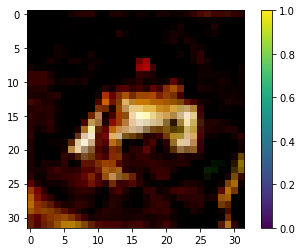

In [25]:
# 학습 데이터 시각화
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

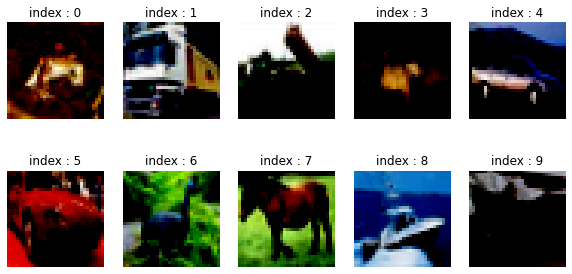

In [26]:
## 다른 것도 출력해봅시다.
plt.figure(figsize=(10,5))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(train_x[i])
    plt.title(f'index : {i}')
    plt.axis("off")
    
plt.show()

In [27]:
# tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성

BUFFER_SIZE = 50000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(train_dataset)

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>


### STEP 2. 생성자 모델 구현하기

In [28]:
# (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.

def make_generator_model():

    # Start
    model = tf.keras.Sequential() # 순차형 모델

    # First: Dense layer
    model.add(layers.Dense(8*8*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 128)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              819200    
_________________________________________________________________
batch_normalization_3 (Batch (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 64)          204800    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)         

In [29]:
# noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
noise = tf.random.normal([1,100])
print(noise)

tf.Tensor(
[[ 0.22331013 -0.4759709   1.2390726  -0.9180028  -0.7527224   0.29287812
   1.192457   -0.1427577  -0.22633977 -0.85216594  0.20115946 -0.77816606
  -0.9953908  -0.17702241  0.62272763  0.03824501  0.15271522  0.548187
   0.5556003   0.6560902  -0.32799733  0.7181552  -0.95562226  1.5484093
   0.01482857  3.5390308   1.0171919  -0.17817558  0.08263229  0.462901
   0.2281566   0.03165404  1.0411291   0.05198457  0.14130013  0.01698766
   0.09963593 -2.281656   -0.37077984 -2.0452285  -0.5336565   0.9863025
   0.65756446 -0.11750861 -1.4270655  -0.6305643   0.16783808 -2.8448603
   0.58261627  1.9566065  -1.017396   -1.8876153   0.01228753  0.8600097
   0.78341633  2.3395574   0.29196793 -0.79087925  0.5237969  -0.33672318
  -1.3583856  -0.6958447  -0.69616175  0.95677423 -2.0249238   2.8580043
  -1.6895436  -2.6691296   0.8288708  -1.9787947   0.33530992  1.3328872
   2.481202    0.67420214  0.14625606  0.11304711 -0.64034057  1.0274292
   1.2390723  -1.8791254   0.04980999 

(1, 32, 32, 3)


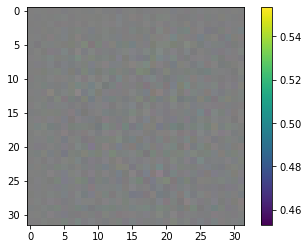

In [30]:
# generator에 넣고 어떻게 나오는지 봅시다 --> 무작위 이미지!

generated_image = generator(noise, training=False)
print(generated_image.shape)

# plt.imshow(generated_image[0, :, :, 0])
plt.imshow((generated_image[0]+1)/2.0)
plt.colorbar()
plt.show()

### STEP 3. 판별자 모델 구현하기

In [31]:
# (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.

def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [32]:
# 모델 확인

discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

In [33]:
# 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00694312]], dtype=float32)>

### STEP 4. 손실함수와 최적화 함수 구현하기

In [34]:
# 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0으로 두었을 때, 
# 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과

# 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워져야 함
# 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워져야 함


# 생성자 손실함수!!
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 판별자 손실함수!!
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [35]:
# 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [36]:
# 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

# 역시 잘 모르겠으면 adam! 무조건 노드를 따라한다!!
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### STEP 5. 훈련과정 상세 기능 구현하기



In [37]:
# 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [38]:
# 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
#         plt.imshow(predictions[i, :, :, 0])
        plt.imshow((predictions[i]+1)/2.0)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [39]:
# 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 
# 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [40]:
# training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### STEP 6. 학습 과정 진행하기


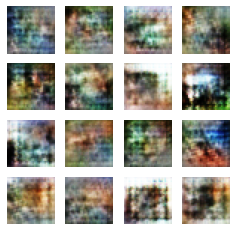

Time for training : 424 sec


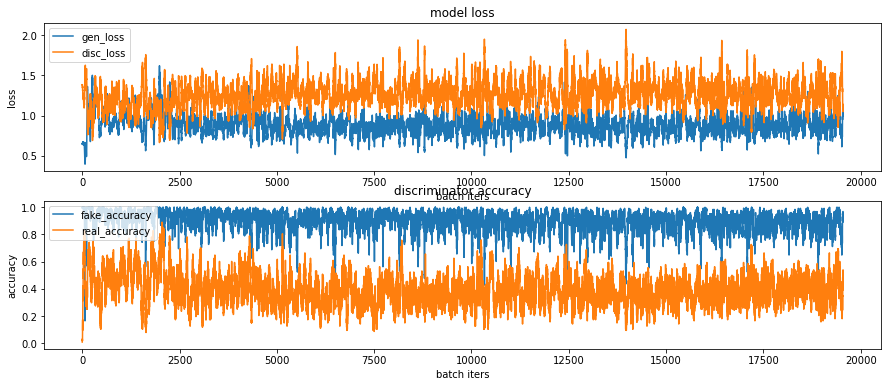

In [41]:
# 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.

def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)
        
save_every = 5 # 모델 저장 간격
EPOCHS = 50 # 학습  에포크

%time
train(train_dataset, EPOCHS, save_every)


In [42]:
# 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 aiffel aiffel 1179493  2월 18 15:08 /home/aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


In [22]:
# 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

## 가능할까?!